In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import itertools as it
import scipy.stats.qmc as ssq
from scipy.stats import chisquare, truncnorm
from seaborn import displot
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from skopt import BayesSearchCV
from skopt.space.space import Real, Integer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, KBinsDiscretizer
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer

np.set_printoptions(threshold=100_000)
X = pd.read_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\ensemble_output\results\default\parameters.csv")
# X = X[['gamma_g', 't_peak', 'gamma_d', 'sd_antarctic',
#        'rho_greenland', 'rho_gmsl', 'temperature_0', 'ocean_heat_0', 'Q10',
#        'CO2_diffusivity', 'heat_diffusivity', 'rf_scale_aerosol',
#        'climate_sensitivity', 'thermal_alpha', 'greenland_a', 'greenland_b',
#        'greenland_alpha', 'greenland_beta', 'anto_alpha', 'antarctic_mu',
#        'antarctic_precip0', 'antarctic_runoff_height0', 'antarctic_lambda',
#        'antarctic_temp_threshold', 'lw_random_sample']].copy()
Y = pd.read_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\ensemble_output\results\default\gmslr.csv")
Y = Y.mean(axis=1).rename('output')
X.t_peak = X.t_peak.astype('category')
obj = X.join(Y, how='left')
obj.sort_values(by='t_peak',ascending=True, inplace=True)
# Rescaling the dataset
# min_max = MinMaxScaler()
# min_max.fit(obj.iloc[:,:-1],obj.iloc[:,-1])

# obj_scaled = min_max.transform(obj.iloc[:,:-1])
# obj_y = obj.iloc[:,-1].copy()


In [2]:
nun = len(X.t_peak.unique())
discret = KBinsDiscretizer(n_bins=nun, encode='ordinal', random_state=0)
Y_binned = discret.fit_transform(Y.to_numpy().reshape(-1,1)).ravel()
smote = SMOTENC(categorical_features=['t_peak'],sampling_strategy='auto', random_state=0)
X_res , y_res = smote.fit_resample(X, Y_binned)

In [3]:
Y1 = pd.Series(discret.inverse_transform(y_res.reshape(-1,1)).ravel(), name='output')
obj1 = X_res.join(Y1, how='left')

In [4]:
obj1.sort_values(by='t_peak', inplace=True)

In [5]:
obj1

,gamma_g,t_peak,gamma_d,sd_temp,sd_ocean_heat,sd_glaciers,sd_greenland,sd_antarctic,sd_gmsl,rho_temperature,...,antarctic_kappa,antarctic_flow0,antarctic_runoff_height0,antarctic_c,antarctic_bed_height0,antarctic_slope,antarctic_lambda,antarctic_temp_threshold,lw_random_sample,output
16276,0.007032,2030.0,0.144645,0.079195,0.956147,0.000198,0.000258,0.000501,0.001693,0.556753,...,0.051193,1.091393,1088.769941,87.814430,786.867486,0.000717,0.005617,-16.166066,0.000085,0.315824
60434,0.013547,2030.0,0.086745,0.074217,0.529761,0.000066,0.000231,0.000351,0.002021,0.574180,...,0.048803,1.404655,1814.605922,132.399778,773.312080,0.000739,0.013687,-15.455946,0.000295,0.438265
51254,0.010473,2030.0,0.106480,0.077831,3.236026,0.000421,0.000222,0.000569,0.000581,0.461446,...,0.077969,0.921405,1059.688107,114.661609,780.601762,0.000677,0.012714,-16.246661,0.000038,0.409804
85424,0.002159,2030.0,0.161543,0.077272,0.233191,0.000554,0.000243,0.000372,0.001776,0.497281,...,0.036758,1.377534,1868.838490,138.796071,768.440622,0.000692,0.011776,-15.546623,0.000052,0.315824
83384,0.002947,2030.0,0.104271,0.077386,3.041196,0.000252,0.000226,0.000443,0.002437,0.514229,...,0.070303,1.049404,1396.007982,112.968773,803.296236,0.000716,0.007405,-14.962388,0.000283,0.473420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52429,0.013229,2167.0,0.093814,0.080127,1.034033,0.000253,0.000202,0.000538,0.000763,0.518355,...,0.069314,1.460019,1379.251183,117.385686,797.296496,0.000668,0.011739,-16.190533,0.000739,3.286766
26215,0.003130,2169.0,0.022636,0.079961,2.088501,0.000069,0.000217,0.000380,0.001736,0.665597,...,0.065737,1.516385,1673.690577,136.186139,787.740252,0.000562,0.012827,-16.224729,0.000183,2.139371
87383,0.004158,2171.0,0.120120,0.078078,0.375789,0.000049,0.000264,0.000451,0.002437,0.763427,...,0.080312,0.812621,1340.939748,76.307069,798.575153,0.000548,0.009879,-15.795974,0.000354,2.230549
43691,0.007347,2172.0,0.049480,0.072067,2.871035,0.000278,0.000222,0.000539,0.001515,0.628720,...,0.078433,1.567668,1431.133514,120.324753,811.646750,0.000652,0.014322,-15.887230,0.000333,2.072679


In [9]:
pd.set_option('display.max_rows', 100_000)
X_res.t_peak.value_counts().sub(X.t_peak.value_counts())

t_peak
2030.0    0
2031.0    1
2032.0    0
2033.0    0
2034.0    0
2035.0    0
2036.0    0
2037.0    0
2038.0    0
2039.0    1
2040.0    0
2041.0    2
2042.0    1
2043.0    1
2044.0    0
2045.0    5
2046.0    0
2047.0    3
2048.0    0
2049.0    3
2050.0    1
2051.0    0
2052.0    2
2053.0    2
2054.0    0
2055.0    0
2056.0    4
2057.0    2
2058.0    2
2059.0    0
2060.0    3
2061.0    2
2062.0    2
2063.0    1
2064.0    1
2065.0    3
2066.0    1
2067.0    5
2068.0    2
2069.0    4
2070.0    2
2071.0    1
2072.0    3
2073.0    1
2074.0    1
2075.0    2
2076.0    1
2077.0    2
2078.0    3
2079.0    2
2080.0    3
2081.0    3
2082.0    0
2083.0    1
2084.0    3
2085.0    0
2086.0    2
2087.0    3
2088.0    1
2089.0    0
2090.0    1
2091.0    1
2092.0    1
2093.0    2
2094.0    1
2095.0    1
2096.0    0
2097.0    0
2098.0    2
2099.0    0
2100.0    1
2101.0    0
2102.0    2
2103.0    2
2104.0    1
2105.0    2
2106.0    1
2107.0    0
2108.0    1
2109.0    1
2110.0    0
2111.0    0
2112.0   

In [6]:
val = train_test_split(obj1.iloc[:,:-1],obj1.iloc[:,-1],shuffle=False, train_size=0.8, random_state=0)
# val = TimeSeriesSplit(n_splits=4, max_train_size=60_066)
#Darnell MSE8 n_estimators=199, max_depth=26, max_features=30, min_samples_leaf=2,n_jobs=10,
# Darnell MSE10:max_depth=36, max_features=33, n_estimators=300,
# max_depth=38, max_features=17,n_estimators=300
#==================================================================================================
RF = RandomForestRegressor(n_estimators=295, max_features=47, max_depth=55, n_jobs=20,random_state=0)

In [7]:
RF.fit(val[0], val[2])

RandomForestRegressor(max_depth=55, max_features=47, n_estimators=295,
                      n_jobs=20, random_state=0)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(dpi=150)

plt.plot(obj1.t_peak, obj1.output, color='blue', label='True')
plt.plot(obj1.t_peak, RF.predict(obj1.iloc[:,:-1]), color='firebrick', label='Predicted')
plt.title('Test Predictions vs. True Output')
plt.ylabel('Risk Estimate')
plt.xlabel(r'$\tau$ (year of peak emissions)')
plt.legend()

In [ ]:
print(f'Train MSE={np.mean(np.square(val[2].to_numpy()-RF.predict(val[0].to_numpy())))}')
print(f'Test MSE={np.mean(np.square(val[3].to_numpy()-RF.predict(val[1].to_numpy())))}')
# print(f'Importances:\n{RF.feature_importances_}')

In [13]:
parameter_space = dict()
parameter_space['n_estimators'] = Integer(30,300)
# parameter_space['min_samples_split'] = Integer(2,5, prior='uniform')
# parameter_space['min_samples_leaf'] = Integer(1,5)
parameter_space['max_features'] = Integer(10,53)
parameter_space['max_depth'] = Integer(10,80)
# parameter_space['ccp_alpha'] = Real(1e-4, 5e-4)

In [14]:
bae = BayesSearchCV(estimator=RF,search_spaces=parameter_space,verbose=2, n_iter=100, scoring='neg_mean_squared_error', n_points=6, cv=val, n_jobs=24, random_state=0)
bae.fit(obj1.iloc[:,:-1], obj1.iloc[:,-1])
res = pd.DataFrame(bae.cv_results_)
res.to_excel(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\Hyperparameter_Tuning\Darnell_HT_MSE_12.xlsx")
res.to_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\Hyperparameter_Tuning\Darnell_HT_MSE_12.csv")
print(f'Best Parameters:{bae.best_params_} with MSE: {bae.best_score_}')

Fitting 4 folds for each of 6 candidates, totalling 24 fits


C:\Users\dwigh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best Parameters:OrderedDict([('max_depth

In [8]:
rng = np.random.default_rng(seed=0)
def bootstrapp(y_true,y_pred,n_boots):
    rows = len(y_true)
    error = (y_true - y_pred).to_numpy()
    S_CI = np.zeros((n_boots,))
    for i in range(n_boots):
        indx = rng.choice(rows, size=rows, replace=True)
        S_CI[i] = np.mean(np.square(error[indx]))
    return S_CI

In [9]:
def pvi1(data: pd.DataFrame, y_true: np.ndarray[float], f: callable,*, n_boots: int, alpha: float, column_set: dict) -> tuple[pd.DataFrame]:
    rows, columns = data.shape
    npv_columns = column_set
    V_y = np.var(y_true, ddof=1)
    u = dict()
    CI = dict()
    # rolled_data = pd.DataFrame(np.roll(data.copy(),rows//2, axis=0), columns=data.columns)
    rolled_data = np.roll(data.copy(),rows//2, axis=0)
    # for cat,col in npv_columns.items():
    for col in npv_columns:
        d = rolled_data.copy()
        d[:, col] = data[:,col]
        y_pred = f(d)
        u[col] = 1-np.mean(np.square(y_true - y_pred))/(2*V_y)
    #     S_CI = 1 - bootstrapp(y_true,y_pred, n_boots)/(2*V_y)
    #     p0,p1 = np.quantile(S_CI, [alpha,1-alpha])
    #     CI[col] = [p0,p1,p1-p0]
    # CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    # CI.index.name = 'Interactions'
    # CI.columns.name = 'Confidence Interval Difference'
    # SI = pd.DataFrame(u.values(), index=u.keys(), columns=['$P_{i}$'])
    return u

In [10]:
def mod_pvi1(data: pd.DataFrame, y_true: np.ndarray[float], f: callable,*, n_boots: int, alpha: float, column_set: dict) -> tuple[pd.DataFrame]:
    rows, columns = data.shape
    npv_columns = column_set
    V_y = np.var(y_true, ddof=1)
    u = dict()
    CI = dict()
    rolled_data = pd.DataFrame(np.roll(data.copy(),rows//2, axis=0), columns=data.columns)
    # rolled_data = np.roll(data.copy(), rows//2, axis=0)
    for cat, col in npv_columns.items():
        d = rolled_data.copy()
        d[col] = data[col]
        y_pred = f(d)
        u[cat] = 1-np.mean(np.square(y_true - y_pred))/(2*V_y)
        S_CI = 1 - bootstrapp(y_true,y_pred, n_boots)/(2*V_y)
        p0,p1 = np.quantile(S_CI, [alpha,1-alpha])
        CI[cat] = [p0,p1,p1-p0]
    CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    CI.index.name = 'Interactions'
    CI.columns.name = 'Confidence Interval Difference'
    SI = pd.DataFrame(u.values(), index=u.keys(), columns=['$P_{i}$'])
    return u,CI

In [11]:
def pvi_t(data: np.ndarray[float], y_true: np.ndarray[float], f: callable,*,n_boots: int, alpha: float, column_set: list[str]) -> np.ndarray[float]:
    '''
    ===Total-Order Permutation Variable Importances===

        data: your training dataset
        y_pred: your model output (specifically the prediction of your 'data' arg)
        f: in this case, simply RF.predict
    '''
    rows, columns = data.shape
    npv_columns = column_set
    u = np.zeros((columns,))
    V_y = np.var(y_true, ddof=1)
    CI = dict()
    for col in npv_columns:
        d = data.copy()
        d[:, col] = np.roll(data[:, col],rows//2, axis=0)
        y_pred = f(d)
        u[col] = np.mean(np.square(y_true - y_pred))/(2*V_y)
    #     S_CI = bootstrapp(y_true,y_pred, n_boots)/(2*V_y)
    #     p0,p1 = np.quantile(S_CI, [alpha,1-alpha])
    #     CI[col] = [p0,p1,p1-p0]
    # CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    # CI.index.name = 'Interactions'
    # CI.columns.name = 'Confidence Interval Difference'
    # S_t = pd.DataFrame(u.values(), index=u.keys(), columns=[r'$P_{\tau}$'])
    return u

In [12]:
def mod_pvi_t(data: np.ndarray[float], y_true: np.ndarray[float], f: callable,*,n_boots: int, alpha: float, column_set: list[str]) -> np.ndarray[float]:
    '''
    ===Total-Order Permutation Variable Importances===

        data: your training dataset
        y_pred: your model output (specifically the prediction of your 'data' arg)
        f: in this case, simply RF.predict
    '''
    rows, columns = data.shape
    npv_columns = column_set
    u = dict()
    V_y = np.var(y_true,ddof=1 )
    CI = dict()
    for cat,col in npv_columns.items():
        d = data.copy()
        d[col] = np.roll(data[col],rows//2, axis=0)
        y_pred = f(d)
        u[cat] = np.mean(np.square(y_true - y_pred))/(2*V_y)
        S_CI = bootstrapp(y_true,y_pred, n_boots)/(2*V_y)
        p0,p1 = np.quantile(S_CI, [alpha,1-alpha])
        CI[cat] = [p0,p1,p1-p0]
    CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    CI.index.name = 'Interactions'
    CI.columns.name = 'Confidence Interval Difference'
    S_t = pd.DataFrame(u.values(), index=u.keys(), columns=[r'$P_{\tau}$'])
    return u, CI

In [13]:
def pvi2(data: np.ndarray[float], y_true: np.ndarray[float], f: callable,*,S_I: np.ndarray[float] ,n_boots: int, alpha: float, columns_set: dict) -> tuple[np.ndarray[float], list]:
    '''
    ===Second-Order Permutation Variable Importances (Full Matrix)===

        data: your training dataset
        y_pred: your model output (specifically the y_true value)
        f: in this case, simply RF.predict

        S_I: First-Order Importances
        n_boots: number of bootstrap samples
        alpha: parameter for confidence interval [alpha, 1-alpha]
        S_CI: sampling distribution 
        CI: Confidence Intervals
    '''
    rows, columns = data.shape
    npv_columns = columns_set
    n = n_boots
    S = np.zeros((columns, columns))
    CI = dict()
    V_y = np.var(y_true, ddof=1)
    # rolled_data = pd.DataFrame(np.roll(data.copy(),rows//2, axis=0), columns=data.columns)
    rolled_data = np.roll(data.copy(),rows//2, axis=0)
    for col1,col2 in it.combinations(npv_columns, r=2):
        d = rolled_data.copy()
        d[:,[col1, col2]] = data[:,[col1,col2]]
        y_pred = f(d)
        S_cat1 = S_I[col1]
        S_cat2 = S_I[col2]
        print(f'First-Order:\t{S_cat1, S_cat2}')
        # print(f'First Part:\t{np.mean(np.square(y_true - f(d)))/(2*V_y)}')
        # print(f'Second Part:\t{S_cat1}')
        # print(f'Third Part:\t{S_cat2}')
        S[col1, col2] = 1 - np.mean(np.square(y_true - y_pred))/(2*V_y) - S_cat1 - S_cat2
        print(f'Second-Order:\t{S[col1,col2]}')

    #     S_CI = 1 - bootstrapp(y_true,y_pred, n_boots)/(2*V_y) - S_cat1 - S_cat2
    #     p0,p1= np.quantile(S_CI, [alpha,1-alpha])
    #     CI[(col1, col2)] = [p0,p1,p1-p0]
    # CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    # CI.index.name = 'Interactions'
    # CI.columns.name = 'Confidence Interval Difference'

    # S = pd.DataFrame(S.values(), index=S.keys(), columns=[r'$P_{ik}$'])
    return S

In [14]:
def mod_pvi2(data: np.ndarray[float], y_true: np.ndarray[float], f: callable,*,S_I: np.ndarray[float] ,n_boots: int, alpha: float, columns_set: dict) -> tuple[np.ndarray[float], list]:
    '''
    ===Second-Order Permutation Variable Importances (Full Matrix)===

        data: your training dataset
        y_pred: your model output (specifically the y_true value)
        f: in this case, simply RF.predict

        S_I: First-Order Importances
        n_boots: number of bootstrap samples
        alpha: parameter for confidence interval [alpha, 1-alpha]
        S_CI: sampling distribution 
        CI: Confidence Intervals
    '''
    rows, columns = data.shape
    npv_columns = columns_set
    n = n_boots
    S = dict()
    CI = dict()
    V_y = np.var(y_true, ddof=1)
    rolled_data = pd.DataFrame(np.roll(data.copy(),rows//2, axis=0), columns=data.columns)
    # rolled_data = np.roll(data.copy(), rows//2, axis=0)
    for (cat1,col1),(cat2, col2) in it.combinations(npv_columns.items(), r=2):
        col = col1+col2
        d = rolled_data.copy()
        d[col] = data[col]
        y_pred = f(d)
        S_cat1 = S_I[cat1]
        S_cat2 = S_I[cat2]
        S[(cat1, cat2)] = 1 - np.mean(np.square(y_true - y_pred))/(2*V_y) - S_cat1 - S_cat2
        S_CI = 1 - bootstrapp(y_true,y_pred, n_boots)/(2*V_y) - S_cat1 - S_cat2 # Bootstrap Process
        p0,p1= np.quantile(S_CI, [alpha,1-alpha])
        CI[(cat1, cat2)] = [p0,p1,p1-p0]
    CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    CI.index.name = 'Interactions'
    CI.columns.name = 'Confidence Interval Difference'

    # S = pd.DataFrame(S.values(), index=S.keys(), columns=[r'$P_{ik}$'])
    return S, CI

In [15]:
Variables = ['sd_temp', 'sd_ocean_heat', 'sd_glaciers', 'sd_greenland','sd_antarctic',
              'sd_gmsl', 'rho_temperature','rho_ocean_heat', 
              'rho_glaciers', 'rho_greenland', 'rho_antarctic','rho_gmsl']
Climate = ['CO2_0', 'N2O_0', 'temperature_0','ocean_heat_0','Q10', 'CO2_fertilization',
           'CO2_diffusivity', 'heat_diffusivity', 'rf_scale_aerosol','climate_sensitivity']
Glaciers = ['glaciers_v0','glaciers_s0','glaciers_beta0', 'glaciers_n']
Thermals = ['thermal_s0', 'thermal_alpha']

Greenland = ['greenland_a', 'greenland_b','greenland_alpha', 'greenland_beta']
Antarctic = [ 'antarctic_gamma', 'antarctic_alpha','antarctic_mu', 'antarctic_nu',
              'antarctic_precip0', 'antarctic_kappa','antarctic_flow0', 'antarctic_runoff_height0',
                'antarctic_c','antarctic_bed_height0', 'antarctic_slope', 'antarctic_lambda','antarctic_temp_threshold',
                'antarctic_s0','anto_alpha', 'anto_beta']

In [16]:
# column_set = val[0].columns
# print(column_set)
npv_column_set = dict()
npv_column_set['Variables'] = Variables
npv_column_set['Climate'] = Climate
# npv_column_set['Glaciers'] = Glaciers
npv_column_set['Thermals'] = Thermals
npv_column_set['Greenland'] = Greenland
npv_column_set['Antarctic'] = Antarctic
npv_column_set['Emissions'] = ['gamma_g', 't_peak', 'gamma_d', 'lw_random_sample']

In [17]:
PI, CI= mod_pvi1(val[0], val[2], RF.predict, n_boots=1000, alpha=0.05, column_set=npv_column_set)
print(f'First-Order PVi:\n{pd.DataFrame(PI.values(), index=PI.keys())}\n')
print(f'Confidence Intervals:{CI}')

First-Order PVi:
                  0
Variables -0.079953
Climate   -0.068370
Thermals  -0.093844
Greenland -0.086392
Antarctic -0.036234
Emissions  0.110357

Confidence Intervals:Confidence Interval Difference       5th      95th  Quantile Difference
Interactions                                                           
Variables                      -0.088080 -0.071929             0.016151
Climate                        -0.075351 -0.060620             0.014731
Thermals                       -0.101772 -0.086618             0.015154
Greenland                      -0.094054 -0.078600             0.015453
Antarctic                      -0.043844 -0.028835             0.015009
Emissions                       0.102716  0.117563             0.014847


In [18]:
def donut_chart(values: np.ndarray, values1: np.ndarray, labels: list,labels1: list, props: dict, kw: dict):
    fig, ax= plt.subplots(1,2, figsize=(10,10))
    wedges0, text0 = ax[0].pie(values,wedgeprops=props['wedgeprops'],colors=props['colors'], startangle= props['startangle'], textprops = props['textprops'])
    for i, p in enumerate(wedges0):
        ang = (p.theta2-p.theta1)/2 + p.theta1
        x,y = np.cos(np.deg2rad(ang)), np.sin(np.deg2rad(ang))
        horizontalalignment = {-1:'right', 1:'left'}[int(np.sign(x))]
        connectionstyle = f'angle, angleA=0, angleB={ang}'
        kw['arrowprops'].update({'connectionstyle':connectionstyle})
        ax[0].annotate(f'{values[i]: .1%}', xy=(x,y), xytext=(1.1*np.sign(x),1.2*y), horizontalalignment=horizontalalignment, **kw)
    ax[0].set_title('SNEASY-BRICK: First & Second-Order PVi')
    ax[0].legend(labels=labels,loc='center', title='PVi Indices:' )

    wedges1, text1 = ax[1].pie(values1,wedgeprops=props['wedgeprops'],colors=props['colors'], startangle= props['startangle'], textprops = props['textprops'])
    for i, p in enumerate(wedges1):
        ang = (p.theta2-p.theta1)/2 + p.theta1
        x,y = np.cos(np.deg2rad(ang)), np.sin(np.deg2rad(ang))
        horizontalalignment = {-1:'right', 1:'left'}[int(np.sign(x))]
        connectionstyle = f'angle, angleA=0, angleB={ang}'
        kw['arrowprops'].update({'connectionstyle':connectionstyle})
        ax[1].annotate(f'{values1[i]: .1%}', xy=(x,y), xytext=(1.1*np.sign(x),1.2*y), horizontalalignment=horizontalalignment, **kw)
    ax[1].set_title('SNEASY-BRICK: Total-Order PVi')
    ax[1].legend(labels=labels1,loc='center', title='PVi Indices:' )
    plt.show()

In [19]:
PT= mod_pvi_t(val[0], val[2], RF.predict, n_boots=1000, alpha=0.05, column_set=npv_column_set)
PT

({'Variables': np.float64(0.011941326114549847),
  'Climate': np.float64(0.2590960596374863),
  'Thermals': np.float64(0.006626805207867255),
  'Greenland': np.float64(0.012854080072026392),
  'Antarctic': np.float64(0.249766255623056),
  'Emissions': np.float64(0.7499950405789741)},
 Confidence Interval Difference       5th      95th  Quantile Difference
 Interactions                                                           
 Variables                       0.011712  0.012156             0.000443
 Climate                         0.255954  0.262259             0.006306
 Thermals                        0.006495  0.006762             0.000267
 Greenland                       0.012659  0.013051             0.000392
 Antarctic                       0.246971  0.252368             0.005397
 Emissions                       0.744531  0.755535             0.011004)

In [20]:
PIK,CIK= mod_pvi2(val[0], val[2], RF.predict,S_I=PI, n_boots=1000, alpha=0.05, columns_set=npv_column_set)
PIK = pd.DataFrame(PIK.values(), index=PIK.keys(), columns=[r'$P_{ik}$'])

In [21]:
PIK

$P_{ik}$
Variables Climate    0.082139
          Thermals   0.095805
          Greenland  0.092921
          Antarctic  0.080567
          Emissions  0.083405
Climate   Thermals   0.095172
          Greenland  0.089142
          Antarctic  0.036636
          Emissions  0.081693
Thermals  Greenland  0.095957
          Antarctic  0.093422
          Emissions  0.093858
Greenland Antarctic  0.084724
          Emissions  0.091033
Antarctic Emissions  0.050868

In [22]:
PIK.sum(axis=0).to_numpy()+pd.DataFrame(PI.values(), index=PI.keys()).sum(axis=0).to_numpy()

array([0.99290532])

In [23]:
props = dict()
kw = dict()
props['textprops'] = {'fontsize':14}
props['startangle'] = -270
props['wedgeprops'] = {'width': 0.2}
kw['arrowprops'] = dict(arrowstyle='-')
kw['zorder'] = 0
kw['va'] = 'center'
colors = ['#CF0057','#FF0054','#F72585', '#B5179E', '#7209B7', '#560BAD','#8F3DC1','#A96FD1',
          '#C3A3E0', '#8F6FD1', '#480CA8', '#3A0CA3','#141440','#A3A3E0', '#6F6FD1', '#3D3DC1',
          '#4361EE','#4CC9F0','#1DE48D','#6B007B','#B51CE4','#E044A7', '#744EC2']
props['colors'] = colors

In [24]:
PI = pd.DataFrame(PI.values(), index=PI.keys(), columns=[r'$P_{i}$'])

In [25]:
inner = PI.to_dict()[r'$P_{i}$']
inner = {key: value for key, value in inner.items() if value>0}

In [26]:
left_inner = PIK.to_dict()[r'$P_{ik}$']
left_inner = {','.join(key): value for key,value in left_inner.items()}

In [27]:
inner

{'Emissions': 0.11035690888046168}

In [28]:
merged_indices = left_inner|inner
labels = list(merged_indices.keys())
values = list(merged_indices.values())

In [29]:
PT, CT = PT

In [30]:
labels1 = list(PT.keys())
values1 = list(PT.values())

In [31]:
merged_indices

{'Variables,Climate': 0.0821387310183892,
 'Variables,Thermals': 0.09580500304715778,
 'Variables,Greenland': 0.09292069640393885,
 'Variables,Antarctic': 0.08056749373967786,
 'Variables,Emissions': 0.08340511676019147,
 'Climate,Thermals': 0.09517192354333437,
 'Climate,Greenland': 0.089142079851523,
 'Climate,Antarctic': 0.036635650485876026,
 'Climate,Emissions': 0.08169255318250301,
 'Thermals,Greenland': 0.09595711430451748,
 'Thermals,Antarctic': 0.09342213459306103,
 'Thermals,Emissions': 0.09385847952362503,
 'Greenland,Antarctic': 0.08472384665061594,
 'Greenland,Emissions': 0.09103324653066958,
 'Antarctic,Emissions': 0.050868108542760915,
 'Emissions': 0.11035690888046168}

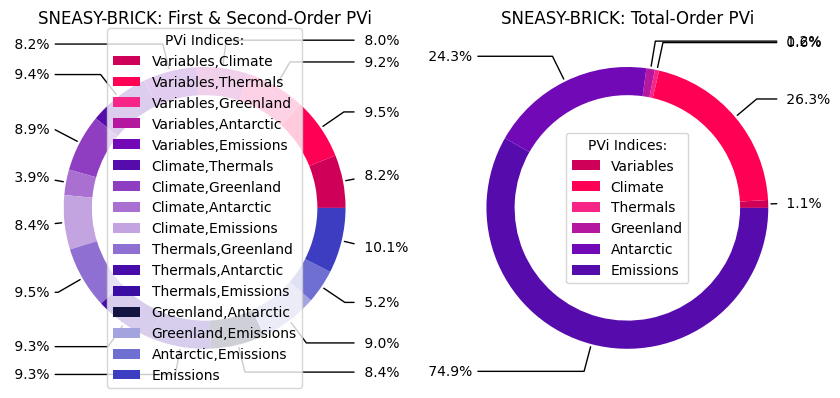

In [53]:
donut_chart(values, values1, labels, labels1, props, kw)

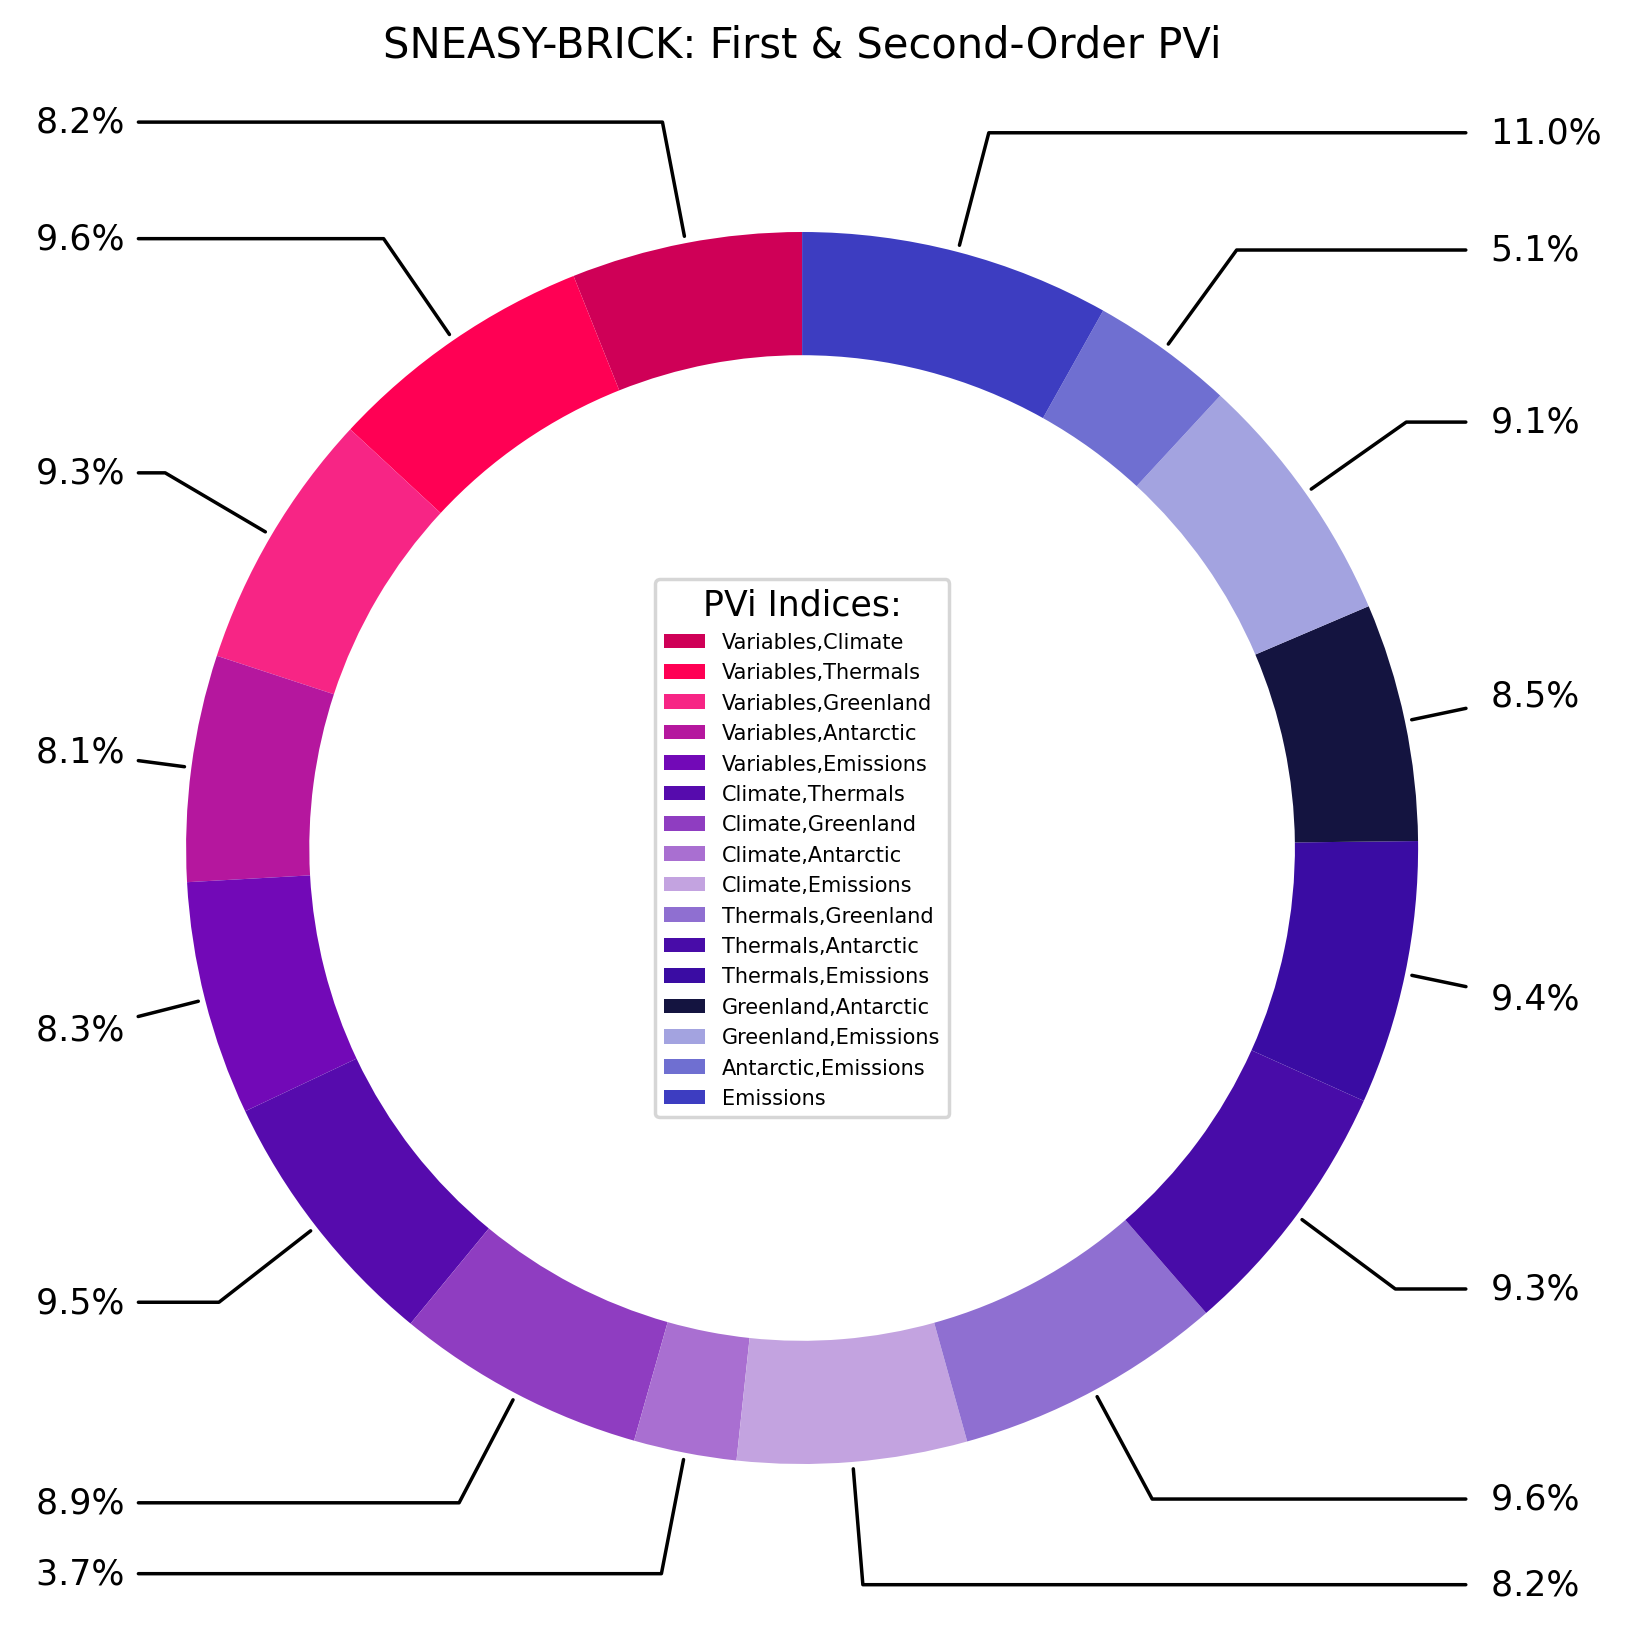

In [32]:
fig, ax= plt.subplots(1,1,dpi=250, figsize=(8,8))
wedges0, text0 = ax.pie(values,wedgeprops=props['wedgeprops'],colors=props['colors'], startangle= props['startangle'], textprops = props['textprops'])
for i, p in enumerate(wedges0):
    ang = (p.theta2-p.theta1)/2 + p.theta1
    x,y = np.cos(np.deg2rad(ang)), np.sin(np.deg2rad(ang))
    horizontalalignment = {-1:'right', 1:'left'}[int(np.sign(x))]
    connectionstyle = f'angle, angleA=0, angleB={ang}'
    kw['arrowprops'].update({'connectionstyle':connectionstyle})
    ax.annotate(f'{values[i]: .1%}', xy=(x,y), xytext=(1.1*np.sign(x),1.2*y), horizontalalignment=horizontalalignment, **kw)
ax.set_title('SNEASY-BRICK: First & Second-Order PVi')
ax.legend(labels=labels,loc='center', title='PVi Indices:' , prop={'size':6})
plt.show()

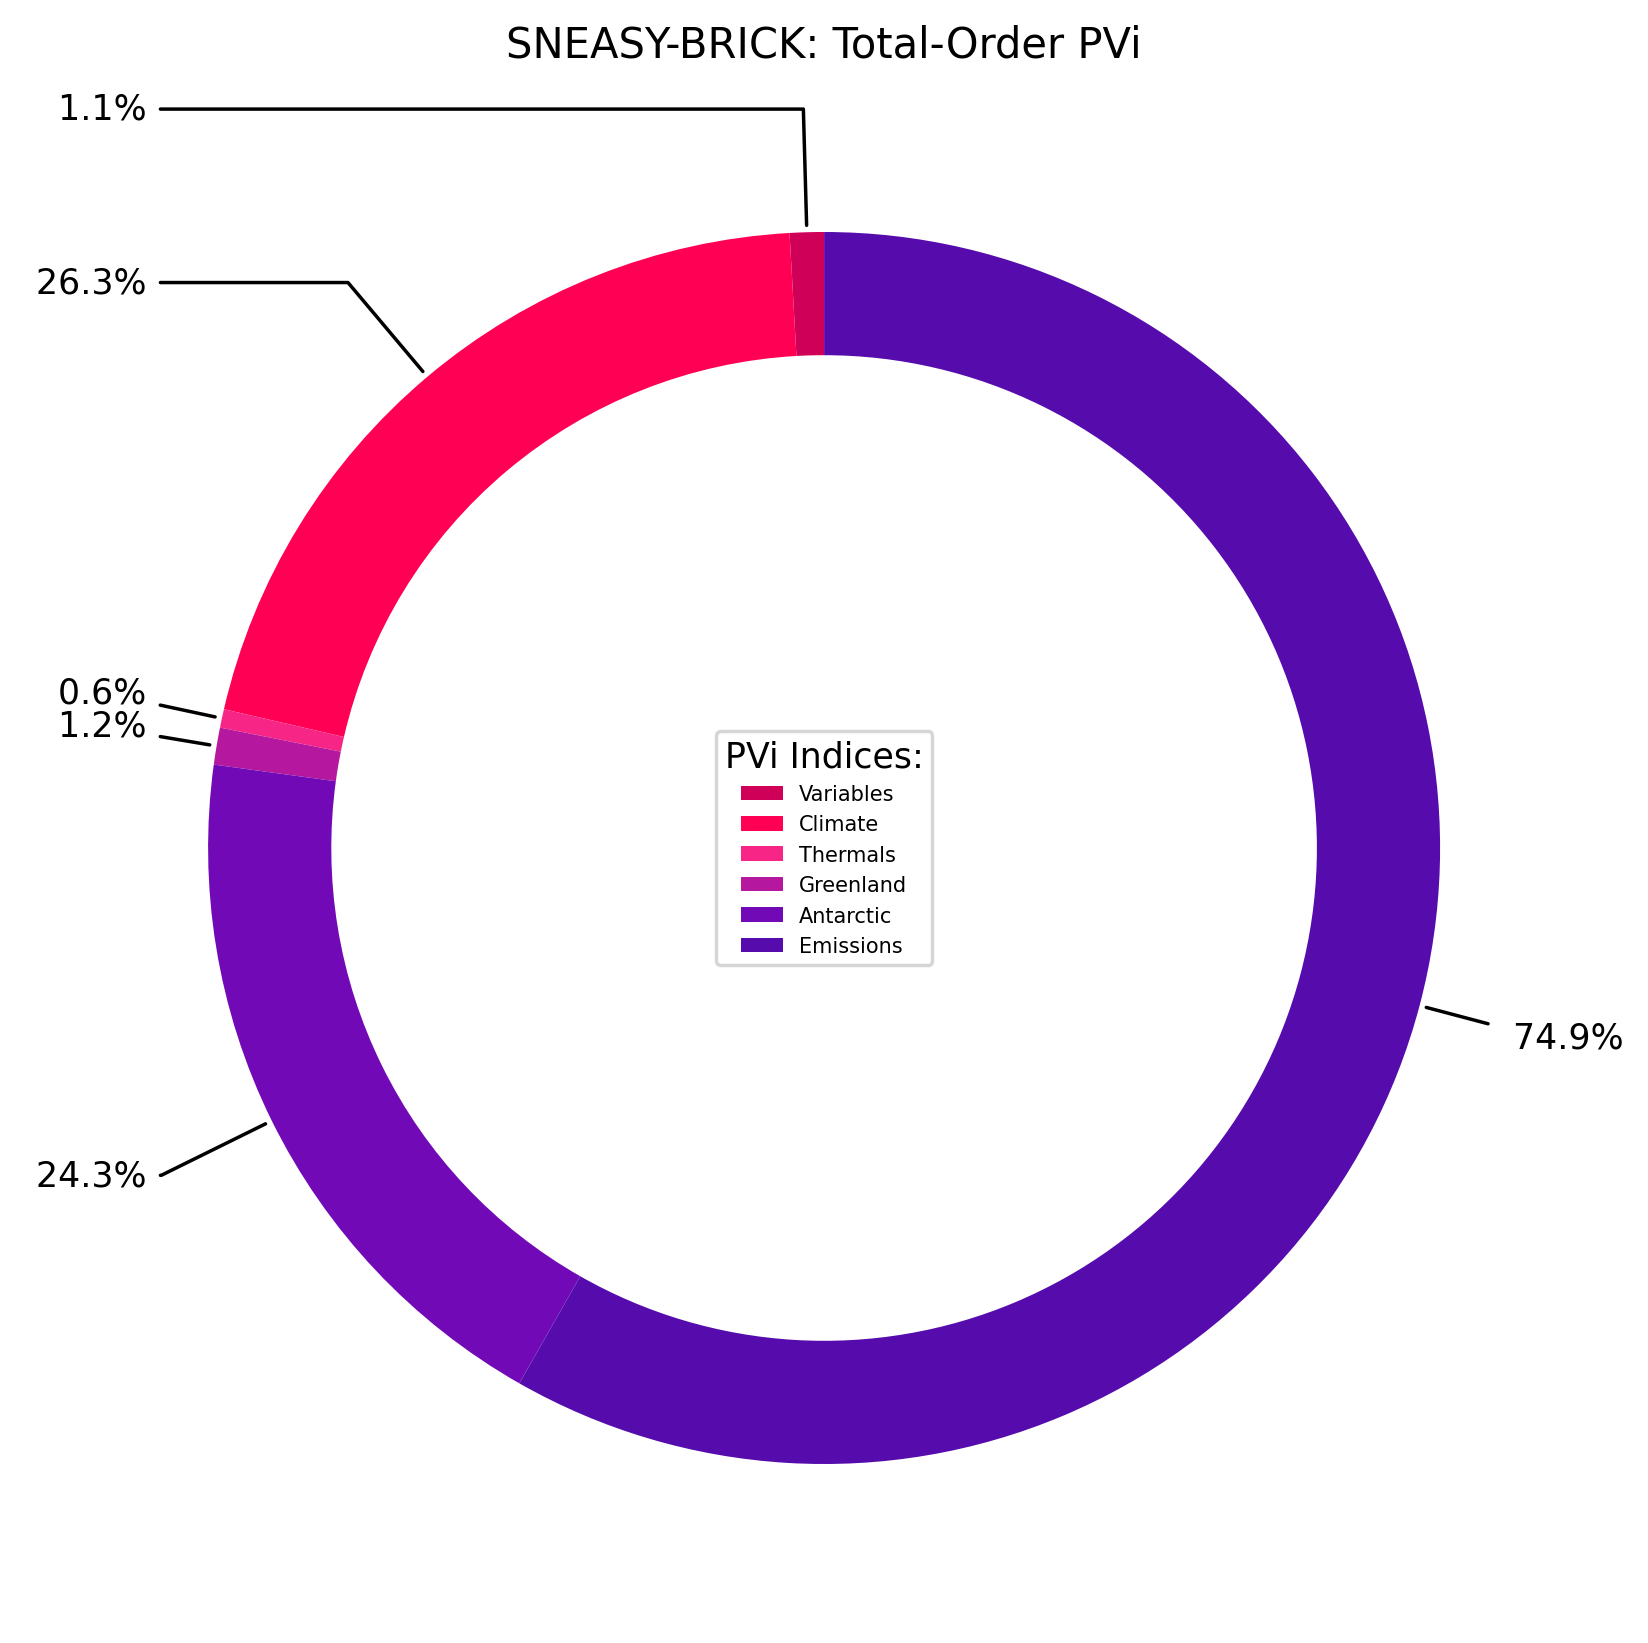

In [62]:
fig, ax= plt.subplots(1,1,dpi=250, figsize=(8,8))
wedges0, text0 = ax.pie(values1,wedgeprops=props['wedgeprops'],colors=props['colors'], startangle= props['startangle'], textprops = props['textprops'])
for i, p in enumerate(wedges0):
    ang = (p.theta2-p.theta1)/2 + p.theta1
    x,y = np.cos(np.deg2rad(ang)), np.sin(np.deg2rad(ang))
    horizontalalignment = {-1:'right', 1:'left'}[int(np.sign(x))]
    connectionstyle = f'angle, angleA=0, angleB={ang}'
    kw['arrowprops'].update({'connectionstyle':connectionstyle})
    ax.annotate(f'{values1[i]: .1%}', xy=(x,y), xytext=(1.1*np.sign(x),1.2*y), horizontalalignment=horizontalalignment, **kw)
ax.set_title('SNEASY-BRICK: Total-Order PVi')
ax.legend(labels=labels1,loc='center', title='PVi Indices:' , prop={'size':6})
plt.show()

In [29]:
PI_CI = PI.join(CI, how='left')
print(PI_CI.to_latex(float_format='{:.4f}'.format))

\begin{tabular}{lrrrr}
\toprule
 & $P_{i}$ & 5th & 95th & Quantile Difference \\
\midrule
Variables & -0.0792 & -0.0865 & -0.0718 & 0.0147 \\
Climate & -0.0618 & -0.0688 & -0.0542 & 0.0146 \\
Thermals & -0.0932 & -0.1004 & -0.0858 & 0.0146 \\
Greenland & -0.0854 & -0.0929 & -0.0779 & 0.0150 \\
Antarctic & -0.0406 & -0.0475 & -0.0340 & 0.0135 \\
Emissions & 0.1008 & 0.0942 & 0.1080 & 0.0139 \\
\bottomrule
\end{tabular}



In [30]:
PT = pd.DataFrame(PT.values(), index=PT.keys(), columns=[r'$P_{\tau}$'])

In [31]:
PT_CT = PT.join(CT, how='left')
print(PT_CT.to_latex(float_format='{:.4f}'.format))

\begin{tabular}{lrrrr}
\toprule
 & $P_{\tau}$ & 5th & 95th & Quantile Difference \\
\midrule
Variables & 0.0115 & 0.0113 & 0.0116 & 0.0003 \\
Climate & 0.2634 & 0.2605 & 0.2663 & 0.0059 \\
Thermals & 0.0062 & 0.0062 & 0.0063 & 0.0002 \\
Greenland & 0.0125 & 0.0123 & 0.0126 & 0.0003 \\
Antarctic & 0.2433 & 0.2408 & 0.2459 & 0.0051 \\
Emissions & 0.7487 & 0.7436 & 0.7535 & 0.0099 \\
\bottomrule
\end{tabular}



In [32]:
PIK_CIK = PIK.join(CIK, how='left')
print(PIK_CIK.to_latex(float_format='{:.4f}'.format))

\begin{tabular}{llrrrr}
\toprule
 &  & $P_{ik}$ & 5th & 95th & Quantile Difference \\
\midrule
\multirow[t]{5}{*}{Variables} & Climate & 0.0816 & 0.0739 & 0.0888 & 0.0148 \\
 & Thermals & 0.0952 & 0.0877 & 0.1028 & 0.0151 \\
 & Greenland & 0.0922 & 0.0847 & 0.0991 & 0.0144 \\
 & Antarctic & 0.0796 & 0.0729 & 0.0867 & 0.0138 \\
 & Emissions & 0.0823 & 0.0751 & 0.0892 & 0.0141 \\
\cline{1-6}
\multirow[t]{4}{*}{Climate} & Thermals & 0.0942 & 0.0874 & 0.1010 & 0.0136 \\
 & Greenland & 0.0885 & 0.0816 & 0.0958 & 0.0142 \\
 & Antarctic & 0.0394 & 0.0323 & 0.0466 & 0.0143 \\
 & Emissions & 0.0836 & 0.0766 & 0.0905 & 0.0139 \\
\cline{1-6}
\multirow[t]{3}{*}{Thermals} & Greenland & 0.0954 & 0.0880 & 0.1032 & 0.0152 \\
 & Antarctic & 0.0928 & 0.0860 & 0.1002 & 0.0142 \\
 & Emissions & 0.0934 & 0.0863 & 0.1005 & 0.0142 \\
\cline{1-6}
\multirow[t]{2}{*}{Greenland} & Antarctic & 0.0837 & 0.0764 & 0.0906 & 0.0142 \\
 & Emissions & 0.0897 & 0.0827 & 0.0970 & 0.0143 \\
\cline{1-6}
Antarctic & Emission

## RF Per Year Category

In [20]:
u_years = obj['t_peak'].unique() # Obtain the unique years
mask = u_years<2100

In [15]:
time_PI = dict()
time_PIK = dict()
time_PT = dict()
for year in u_years[mask]:
    # if year>=2161:
    #     pass
    # else:
    #     # print(year)
    mask = obj['t_peak'] < year
    val1 = train_test_split(obj[mask].iloc[:,:-1], obj[mask].iloc[:,-1], train_size=0.5, random_state=0, shuffle=False)
    RF = RandomForestRegressor(n_jobs=10, random_state=0)
    RF.fit(val1[0], val1[2])
    time_PI[year] = mod_pvi1(val1[0], val1[2], RF.predict, n_boots=1000, alpha=0.05, column_set=npv_column_set)
    time_PT[year] = mod_pvi_t(val1[0], val1[2], RF.predict, n_boots=1000, alpha=0.05, column_set=npv_column_set)
    time_PIK[year] = mod_pvi2(val1[0], val1[2], RF.predict,S_I=time_PI[year], n_boots=1000, alpha=0.05, columns_set=npv_column_set)

In [19]:
res = pd.DataFrame(time_PT.values(), index=time_PT.keys())
res.to_excel(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\Time_PVI\tot_time_PVI.xlsx")
res = pd.DataFrame(time_PI.values(), index=time_PI.keys())
res.to_excel(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\Time_PVI\first_time_PVI.xlsx")


# Feature Selection

We will append a noise feature $S_{\mathrm{var}}\sim \mathcal{N}(\mathbf{\overline{0}}, \sigma^{2})$  to the dataset, to accentuate pertinent features. Thereafter, we select features based upon the total-order PVi contribution of $S_{\mathrm{var}}$, as all features contributing $\leqslant$ are equally insignificant.

In [27]:
# Redefing the TPVi for compatibility
def mpt(data: np.ndarray[float], y_true: np.ndarray[float], f: callable,*,n_boots: int, alpha: float, column_set: list[str]) -> np.ndarray[float]:
    '''
    ===Total-Order Permutation Variable Importances===

        data: your training dataset
        y_pred: your model output (specifically the prediction of your 'data' arg)
        f: in this case, simply RF.predict
    '''
    rows, columns = data.shape
    npv_columns = column_set
    u = dict()
    V_y = np.var(y_true,ddof=1 )
    CI = dict()
    for col in npv_columns:
        d = data.copy()
        d[col] = np.roll(data[col],rows//2, axis=0)
        y_pred = f(d)
        u[col] = np.mean(np.square(y_true - y_pred))/(2*V_y)
        S_CI = bootstrapp(y_true,y_pred, n_boots)/(2*V_y)
        p0,p1 = np.quantile(S_CI, [alpha,1-alpha])
        CI[col] = [p0,p1,p1-p0]
    CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    CI.index.name = 'Interactions'
    CI.columns.name = 'Confidence Interval Difference'
    S_t = pd.DataFrame(u.values(), index=u.keys(), columns=[r'$P_{\tau}$'])
    return u, CI

In [5]:
X = pd.read_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\ensemble_output\results\default\parameters.csv")
# X.drop(columns=list(feat_tb_dropped), inplace=True)
Y = pd.read_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\ensemble_output\results\default\gmslr.csv")
Y = Y.mean(axis=1).rename('output')
obj = X.join(Y, how='left')
S_var = truncnorm.rvs(0, 1,loc=0,scale=1, size=obj.shape[0], random_state=0)
obj.insert(0, 'S_var',S_var)
obj.sort_values(by='t_peak',ascending=True, inplace=True)

In [6]:
obj

,S_var,gamma_g,t_peak,gamma_d,sd_temp,sd_ocean_heat,sd_glaciers,sd_greenland,sd_antarctic,sd_gmsl,...,antarctic_kappa,antarctic_flow0,antarctic_runoff_height0,antarctic_c,antarctic_bed_height0,antarctic_slope,antarctic_lambda,antarctic_temp_threshold,lw_random_sample,output
93380,0.661653,0.005979,2030.0,0.091974,0.074738,2.503238,0.000198,0.000232,0.000383,0.000405,...,0.072566,1.072699,1240.514180,79.039386,762.770179,0.000707,0.008297,-15.740854,0.000261,0.430777
59366,0.176236,0.009668,2030.0,0.081546,0.081082,1.851315,0.000132,0.000251,0.000502,0.001941,...,0.076086,1.323465,1014.354512,126.821100,807.992695,0.000624,0.013372,-15.546083,0.000092,0.347866
21496,0.961334,0.002629,2030.0,0.149528,0.082100,1.756363,0.000159,0.000247,0.000475,0.002613,...,0.059001,1.328616,1737.814817,119.263273,809.343880,0.000708,0.006230,-15.540414,0.000242,0.365387
92776,0.269813,0.003917,2030.0,0.081056,0.087278,2.841193,0.000082,0.000239,0.000466,0.001685,...,0.054435,0.993865,1136.483270,140.548806,816.925800,0.000684,0.006855,-15.453124,0.000164,0.390832
8414,0.583999,0.008057,2030.0,0.112075,0.077741,1.353660,0.000495,0.000276,0.000340,0.001981,...,0.055346,1.470483,991.781103,97.797643,807.736344,0.000556,0.010325,-14.959565,0.000641,0.491800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52429,0.279721,0.013229,2167.0,0.093814,0.080127,1.034033,0.000253,0.000202,0.000538,0.000763,...,0.069314,1.460019,1379.251183,117.385686,797.296496,0.000668,0.011739,-16.190533,0.000739,3.135588
26215,0.795330,0.003130,2169.0,0.022636,0.079961,2.088501,0.000069,0.000217,0.000380,0.001736,...,0.065737,1.516385,1673.690577,136.186139,787.740252,0.000562,0.012827,-16.224729,0.000183,2.118476
87383,0.482222,0.004158,2171.0,0.120120,0.078078,0.375789,0.000049,0.000264,0.000451,0.002437,...,0.080312,0.812621,1340.939748,76.307069,798.575153,0.000548,0.009879,-15.795974,0.000354,2.240000
43691,0.265474,0.007347,2172.0,0.049480,0.072067,2.871035,0.000278,0.000222,0.000539,0.001515,...,0.078433,1.567668,1431.133514,120.324753,811.646750,0.000652,0.014322,-15.887230,0.000333,2.066674


In [7]:
# Model Fitting
val1 = train_test_split(obj.iloc[:,:-1],obj.iloc[:,-1], shuffle=False, train_size=0.8,random_state=0)
RF1 = RandomForestRegressor(n_estimators=300,n_jobs=15, random_state=0)
RF1.fit(val1[0],val1[2])
RF1.feature_importances_

array([0.002425  , 0.0412018 , 0.29871423, 0.15855444, 0.00163895,
       0.00157313, 0.00166895, 0.00175896, 0.00199543, 0.00175155,
       0.0016761 , 0.0015935 , 0.0015887 , 0.00227247, 0.00164234,
       0.00228965, 0.00167951, 0.00162659, 0.00222062, 0.00209154,
       0.00160191, 0.00170484, 0.00169743, 0.00161598, 0.00158907,
       0.00546377, 0.00172747, 0.00215739, 0.00181245, 0.00825612,
       0.18401668, 0.00215931, 0.00316615, 0.00410993, 0.00217471,
       0.00469988, 0.00151324, 0.00161996, 0.001961  , 0.0015875 ,
       0.00158205, 0.00165571, 0.00606552, 0.00170234, 0.00245725,
       0.00174662, 0.00189298, 0.00202606, 0.00170371, 0.00157157,
       0.00154796, 0.08738543, 0.12109037, 0.00297421])

In [22]:
print(f'Train MSE={np.mean(np.square(val1[2].to_numpy()-RF1.predict(val1[0].to_numpy())))}')
print(f'Test MSE={np.mean(np.square(val1[3].to_numpy()-RF1.predict(val1[1].to_numpy())))}')

C:\Users\dwigh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Train MSE=0.013376952723099703


C:\Users\dwigh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Test MSE=0.43273732676361276


In [8]:
def mpv1(data: pd.DataFrame, y_true: np.ndarray[float], f: callable,*, n_boots: int, alpha: float, column_set: dict) -> tuple[pd.DataFrame]:
    rows, columns = data.shape
    npv_columns = column_set
    V_y = np.var(y_true, ddof=1)
    u = dict()
    CI = dict()
    rolled_data = pd.DataFrame(np.roll(data.copy(),rows//2, axis=0), columns=data.columns)
    # rolled_data = np.roll(data.copy(), rows//2, axis=0)
    for col in npv_columns:
        d = rolled_data.copy()
        d[col] = data[col]
        y_pred = f(d)
        u[col] = 1-np.mean(np.square(y_true - y_pred))/(2*V_y)
        S_CI = 1 - bootstrapp(y_true,y_pred, n_boots)/(2*V_y)
        p0,p1 = np.quantile(S_CI, [alpha,1-alpha])
        CI[col] = [p0,p1,p1-p0]
    CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    CI.index.name = 'Interactions'
    CI.columns.name = 'Confidence Interval Difference'
    SI = pd.DataFrame(u.values(), index=u.keys(), columns=['$P_{i}$'])
    return u,CI

In [9]:
def mpv2(data: np.ndarray[float], y_true: np.ndarray[float], f: callable,*,S_I: np.ndarray[float] ,n_boots: int, alpha: float, columns_set: dict) -> tuple[np.ndarray[float], list]:
    '''
    ===Second-Order Permutation Variable Importances (Full Matrix)===

        data: your training dataset
        y_pred: your model output (specifically the y_true value)
        f: in this case, simply RF.predict

        S_I: First-Order Importances
        n_boots: number of bootstrap samples
        alpha: parameter for confidence interval [alpha, 1-alpha]
        S_CI: sampling distribution 
        CI: Confidence Intervals
    '''
    rows, columns = data.shape
    npv_columns = columns_set
    n = n_boots
    S = dict()
    CI = dict()
    V_y = np.var(y_true, ddof=1)
    rolled_data = pd.DataFrame(np.roll(data.copy(),rows//2, axis=0), columns=data.columns)
    # rolled_data = np.roll(data.copy(), rows//2, axis=0)
    for col1, col2 in it.combinations(npv_columns, r=2):
        d = rolled_data.copy()
        d[[col1,col2]] = data[[col1,col2]]
        y_pred = f(d)
        S_cat1 = S_I[col1]
        S_cat2 = S_I[col2]
        S[(col1, col2)] = 1 - np.mean(np.square(y_true - y_pred))/(2*V_y) - S_cat1 - S_cat2
        S_CI = 1 - bootstrapp(y_true,y_pred, n_boots)/(2*V_y) - S_cat1 - S_cat2 # Bootstrap Process
        p0,p1= np.quantile(S_CI, [alpha,1-alpha])
        CI[(col1, col2)] = [p0,p1,p1-p0]
    CI = pd.DataFrame(CI.values(), index = CI.keys(), columns=['5th','95th','Quantile Difference'])
    CI.index.name = 'Interactions'
    CI.columns.name = 'Confidence Interval Difference'

    # S = pd.DataFrame(S.values(), index=S.keys(), columns=[r'$P_{ik}$'])
    return S, CI

In [12]:
PI, CI = mpv1(val1[0], val1[2], RF1.predict, n_boots=1000, alpha=0.05, column_set=val1[0].columns)
PI = pd.DataFrame(PI.values(), index=PI.keys())
np.set_printoptions(threshold=10_000)
print(PI)
print(CI)

                                 0
S_var                    -0.095985
gamma_g                  -0.071276
t_peak                    0.096143
gamma_d                  -0.069282
sd_temp                  -0.096289
sd_ocean_heat            -0.096320
sd_glaciers              -0.096199
sd_greenland             -0.095948
sd_antarctic             -0.095818
sd_gmsl                  -0.096040
rho_temperature          -0.096156
rho_ocean_heat           -0.096263
rho_glaciers             -0.096255
rho_greenland            -0.095308
rho_antarctic            -0.096153
rho_gmsl                 -0.095131
CO2_0                    -0.096164
N2O_0                    -0.096210
temperature_0            -0.094748
ocean_heat_0             -0.095132
thermal_s0               -0.096266
greenland_v0             -0.096185
glaciers_v0              -0.096163
glaciers_s0              -0.096317
antarctic_s0             -0.096269
Q10                      -0.092250
CO2_fertilization        -0.096060
CO2_diffusivity     

In [13]:
PIK, CIK = mpv2(val1[0], val1[2], RF1.predict,S_I=PI.to_dict()[0], n_boots=1000, alpha=0.05, columns_set=val1[0].columns)
PIK = pd.DataFrame(PIK.values(), index=PIK.keys())
PIK

0
S_var                    gamma_g                   0.096795
                         t_peak                    0.096147
                         gamma_d                   0.096531
                         sd_temp                   0.097439
                         sd_ocean_heat             0.097452
...                                                     ...
antarctic_slope          antarctic_temp_threshold  0.096608
                         lw_random_sample          0.097420
antarctic_lambda         antarctic_temp_threshold  0.077427
                         lw_random_sample          0.096454
antarctic_temp_threshold lw_random_sample          0.096068

[1431 rows x 1 columns]

In [14]:
innerik = PIK.to_dict()[0]
innerik

{('S_var', 'gamma_g'): 0.09679474472139882,
 ('S_var', 't_peak'): 0.096147059189572,
 ('S_var', 'gamma_d'): 0.09653090602433956,
 ('S_var', 'sd_temp'): 0.09743916589394308,
 ('S_var', 'sd_ocean_heat'): 0.09745151322948264,
 ('S_var', 'sd_glaciers'): 0.0974386160611338,
 ('S_var', 'sd_greenland'): 0.09744007814496847,
 ('S_var', 'sd_antarctic'): 0.09744303410819866,
 ('S_var', 'sd_gmsl'): 0.09745071275323669,
 ('S_var', 'rho_temperature'): 0.09745356292019558,
 ('S_var', 'rho_ocean_heat'): 0.0974401081256675,
 ('S_var', 'rho_glaciers'): 0.09744757635657364,
 ('S_var', 'rho_greenland'): 0.09744063702989458,
 ('S_var', 'rho_antarctic'): 0.09744287269020702,
 ('S_var', 'rho_gmsl'): 0.09741816288645233,
 ('S_var', 'CO2_0'): 0.0974449688483634,
 ('S_var', 'N2O_0'): 0.09744755847253095,
 ('S_var', 'temperature_0'): 0.09741705613047391,
 ('S_var', 'ocean_heat_0'): 0.0974327438878555,
 ('S_var', 'thermal_s0'): 0.09744550892187243,
 ('S_var', 'greenland_v0'): 0.0974427196550327,
 ('S_var', 'glac

In [15]:
PIK_S_var = {key: innerik[key] for key in innerik.keys() if 'S_var' in key}

In [16]:
avg_svar = np.mean(list(PIK_S_var.values()))
std_svar = np.std(list(PIK_S_var.values())) # Average S_var interaction

In [17]:
avg_svar - std_svar

np.float64(0.0969970646495999)

In [24]:
PIK_Svar_complement = innerik.keys()-PIK_S_var.keys()
ps_comp_values = {key: innerik[key] for key in PIK_Svar_complement}
li = [[key, ps_comp_values[key]]for key in ps_comp_values.keys() if ps_comp_values[key]>avg_svar]
si = {key: ps_comp_values[key] for key in ps_comp_values.keys() if ps_comp_values[key]<avg_svar-std_svar}

In [ ]:
print(len(list(filter(lambda x: x>np.asarray(PIK_S_var).any(), PIK.values()))))

In [28]:
PT, CT = mpt(val1[0], val1[2], RF1.predict, n_boots=1000, alpha=0.05, column_set=val1[0].columns)

In [29]:
PT = pd.Series(PT.values(), index=PT.keys())
PT

S_var                       0.006022
gamma_g                     0.051081
t_peak                      0.615576
gamma_d                     0.188762
sd_temp                     0.005844
sd_ocean_heat               0.005826
sd_glaciers                 0.005852
sd_greenland                0.005898
sd_antarctic                0.005996
sd_gmsl                     0.005898
rho_temperature             0.005849
rho_ocean_heat              0.005827
rho_glaciers                0.005833
rho_greenland               0.006112
rho_antarctic               0.005845
rho_gmsl                    0.006224
CO2_0                       0.005863
N2O_0                       0.005843
temperature_0               0.006129
ocean_heat_0                0.006048
thermal_s0                  0.005827
greenland_v0                0.005876
glaciers_v0                 0.005871
glaciers_s0                 0.005839
antarctic_s0                0.005832
Q10                         0.008501
CO2_fertilization           0.005885
C

In [30]:
# Features <= the importance of S_var
feat_tb_dropped = PT[PT<=PT.loc['S_var']].dropna()

In [31]:
feat_tb_dropped = set(feat_tb_dropped.index) - {'S_var'}

In [32]:
feat_tb_dropped

{'CO2_0',
 'CO2_fertilization',
 'N2O_0',
 'antarctic_alpha',
 'antarctic_bed_height0',
 'antarctic_c',
 'antarctic_flow0',
 'antarctic_gamma',
 'antarctic_kappa',
 'antarctic_nu',
 'antarctic_runoff_height0',
 'antarctic_s0',
 'antarctic_slope',
 'anto_alpha',
 'anto_beta',
 'glaciers_beta0',
 'glaciers_n',
 'glaciers_s0',
 'glaciers_v0',
 'greenland_v0',
 'heat_diffusivity',
 'rho_antarctic',
 'rho_glaciers',
 'rho_ocean_heat',
 'rho_temperature',
 'sd_antarctic',
 'sd_glaciers',
 'sd_gmsl',
 'sd_greenland',
 'sd_ocean_heat',
 'sd_temp',
 'thermal_s0'}

Now that I've found the features contributing little to the predicition of the model output, we can remove them and re-train, validate, and test our the new RF model.

**Reloading the dataset**

In [33]:
X = pd.read_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\ensemble_output\results\default\parameters.csv")
X.drop(columns=list(feat_tb_dropped), inplace=True)
Y = pd.read_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\ensemble_output\results\default\gmslr.csv")
Y = Y.mean(axis=1).rename('output')
obj = X.join(Y, how='left')
obj.sort_values(by='t_peak',ascending=True, inplace=True)

In [34]:
obj.head(5)

,gamma_g,t_peak,gamma_d,rho_greenland,rho_gmsl,temperature_0,ocean_heat_0,Q10,CO2_diffusivity,rf_scale_aerosol,...,greenland_a,greenland_b,greenland_alpha,greenland_beta,antarctic_mu,antarctic_precip0,antarctic_lambda,antarctic_temp_threshold,lw_random_sample,output
93380,0.005979,2030.0,0.091974,0.950883,0.678079,0.033686,-22.947913,1.303913,28.994673,1.244403,...,-2.395422,8.097915,0.000282,0.000089,13.088498,1.363623,0.008297,-15.740854,0.000261,0.430777
59366,0.009668,2030.0,0.081546,0.945117,0.989758,0.027722,-19.809221,1.019227,23.695857,1.067065,...,-3.175112,8.696699,0.000361,0.000063,8.523363,0.703612,0.013372,-15.546083,0.000092,0.347866
21496,0.002629,2030.0,0.149528,0.909948,0.328468,0.021071,-25.459369,2.990259,31.090760,0.969396,...,-1.757312,8.062385,0.000638,0.000004,9.928593,1.097798,0.006230,-15.540414,0.000242,0.365387
92776,0.003917,2030.0,0.081056,0.963076,0.984641,0.021712,-21.460547,1.319239,17.940471,1.062567,...,-2.174618,8.108671,0.000722,0.000029,8.598635,0.652362,0.006855,-15.453124,0.000164,0.390832
8414,0.008057,2030.0,0.112075,0.834579,0.996709,0.046940,-17.479377,1.151990,24.804244,1.330462,...,-3.528285,8.504783,0.000380,0.000019,11.875231,0.212288,0.010325,-14.959565,0.000641,0.491800


**Model Validation/Calibration No.1**\
As this is a time-series dataset, we define a new variable ```val2``` that partitions the dataset (w/o shuffling) into train/validation. When it's time to 'test' the performance of the model, we will switch to ```train_test_split```.

In [35]:
# val2 = train_test_split(obj.iloc[:,:-1],obj.iloc[:,-1],shuffle=False, train_size=0.8, random_state=0)
val2 = TimeSeriesSplit(n_splits=4, max_train_size=60_000)
RF = RandomForestRegressor(random_state=0)

**Model Validation/Calibration No.2**\
Defining the parameter space.

In [37]:
parameter_space = dict()
parameter_space['n_estimators'] = Integer(30,400)
# parameter_space['min_samples_split'] = Integer(2,5, prior='uniform')
# parameter_space['min_samples_leaf'] = Integer(1,5)
parameter_space['max_features'] = Integer(5,22)
parameter_space['max_depth'] = Integer(10,80)
# parameter_space['ccp_alpha'] = Real(1e-4, 5e-4)

In [38]:
bae = BayesSearchCV(estimator=RF,search_spaces=parameter_space,verbose=2, n_iter=100, scoring='neg_mean_squared_error', n_points=6, cv=val2, n_jobs=24, random_state=0)
bae.fit(obj.iloc[:,:-1], obj.iloc[:,-1])
res = pd.DataFrame(bae.cv_results_)
res.to_excel(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\Hyperparameter_Tuning\Darnell_HT_MSE_SF_2.xlsx")
res.to_csv(r"C:\Users\dwigh\OneDrive\Desktop\Emissions Uncertainty on Antarctic Instability\Hyperparameter_Tuning\Darnell_HT_MSE_SF_2.csv")
print(f'Best Parameters:{bae.best_params_} with MSE: {bae.best_score_}')

Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Fitting 4 folds for each of 4 candidates

In [39]:
val2 = train_test_split(obj.iloc[:,:-1],obj.iloc[:,-1],shuffle=False, train_size=0.8, random_state=0)
RF1 = RandomForestRegressor(n_estimators=316, max_features=20, max_depth=44, n_jobs=20, random_state=0)
RF1.fit(val2[0], val2[2])

RandomForestRegressor(max_depth=44, max_features=20, n_estimators=316,
                      n_jobs=20, random_state=0)

In [40]:
print(f'Train MSE={np.mean(np.square(val2[2].to_numpy()-RF1.predict(val2[0].to_numpy())))}')
print(f'Test MSE={np.mean(np.square(val2[3].to_numpy()-RF1.predict(val2[1].to_numpy())))}')

C:\Users\dwigh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Train MSE=0.0019965492353256654
Test MSE=0.10538290164889938


C:\Users\dwigh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


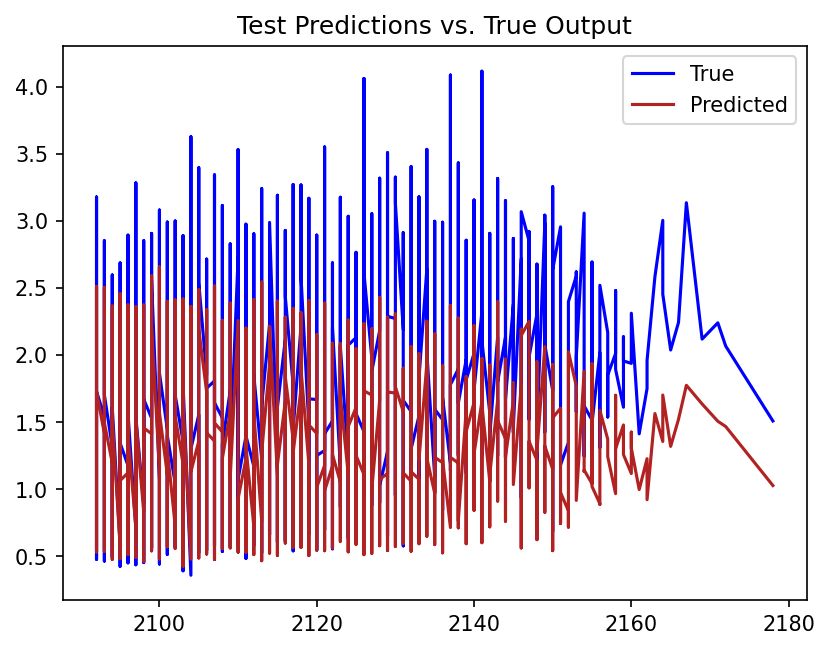

In [41]:
import matplotlib.pyplot as plt

plt.figure(dpi=150)

plt.plot(val2[1].t_peak, val2[3], color='blue', label='True')
plt.plot(val2[1].t_peak, RF1.predict(val2[1]), color='firebrick', label='Predicted')
plt.title('Test Predictions vs. True Output')
plt.legend()

In [65]:
PI, CI = mpv1(val2[0], val2[2], RF1.predict, n_boots=1000, alpha=0.05, column_set=val2[0].columns)
PIK, CIK = mpv2(val2[0], val2[2], RF1.predict,S_I=PI, n_boots=1000, alpha=0.05, columns_set=val2[0].columns)

In [ ]:
pd.set_option('display.max_rows', 10000)
PIK = pd.DataFrame(PIK.values(),index=PIK.keys())
PIK

In [72]:
pd.set_option('display.max_rows', 10000)

In [ ]:
PIK

In [ ]:
CIK